In [23]:
%load_ext autoreload
%autoreload 2

import __confing
__confing.change_to_root_folder()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: c:\Users\Leo\OneDrive\Escritorio\Final Proyect


In [24]:
try:
    __confing.execute_notebook('notebooks/data_extract.ipynb')
except:
    pass

In [25]:
import pandas as pd
import numpy as np

from src import value_filler as vf
from src import feature_selection as fs
from src import data_procces as dp

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error,roc_auc_score,confusion_matrix,recall_score,confusion_matrix,f1_score 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def feature_importance(model, X: pd.DataFrame, y: pd.Series, n: int):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    feature_names_original = list(X.columns)
    
    target_name = y.name  # Obtener el nombre de la columna objetivo desde la Serie y
    
    if target_name in feature_names_original:
        feature_names_original.remove(target_name)
    
    max_importance = list(indices[:n])
    
    nueva_lista = [feature_names_original[i] for i in max_importance]
    
    return nueva_lista

def proba_dist(model, X_test):
    with plt.style.context('fivethirtyeight'):
        sns.histplot(model.predict_proba(X_test), bins=50)
        plt.title("Probability distribution for each Target category")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        plt.show()


In [27]:
n='a'
df=pd.read_csv(r'data\custom\all_waves.csv')
df = df.loc[df['paagey'] >= 50]
target=f'p{n}hosp1y'

In [28]:
selected=['pahosp1y','pahipe_m', 'padadage', 'pamomage', 'pahibpe', 'palunge_m', 'pacholst', 'pagrossaa', 'paosleep', 'pafallinj', 'pacancre', 'paswell', 'pachair', 'parafaany', 'pawheeze', 'paagey', 'paarthre', 'padiabe', 'parjudg', 'paweight', 'paclims', 'pastroke', 'pabathehlp', 'pasmokev', 'pahearaid', 'pameds', 'paheight', 'paglasses', 'paeat', 'papaina', 'pagender', 'padrinkb']
len(selected)

32

In [29]:
df3 = df.where(df['cpindex'] <=  107.69).dropna(subset=['cpindex'])

In [30]:
selected = list(set(selected))

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

In [31]:
porcentaje_nulos = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (porcentaje_nulos <= 0.5)]

In [32]:
# fill
y = df_s[target]
X = df_s.drop(target,axis=1)

In [33]:
X = fs.fast_fill(X)
X=X.sort_index(axis=1)

In [34]:
scaler = StandardScaler()
X=scaler.fit_transform(X)

transformer = PowerTransformer(method='yeo-johnson')
X=transformer.fit_transform(X)
pass

In [35]:
# split
X_train, X_test, y_train, y_test=dp.split_data(X, y, test_size=0.2, random_state=40)

In [36]:
# smote
X_train, y_train = dp.apply_smote(X_train, y_train)

In [37]:
zeros=y_train.value_counts()[0]
unos=y_train.value_counts()[1]

In [38]:
params={'max_depth': 8, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.05568753700048324, 
        'min_child_weight': 4, 
        'learning_rate': 0.0799908981133205, 
        'n_estimators': 571,
        'scale_pos_weight': (zeros/unos)-1.6 #-1.6
        }

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
model = XGBClassifier(**params)
model.fit(X_train, y_train)

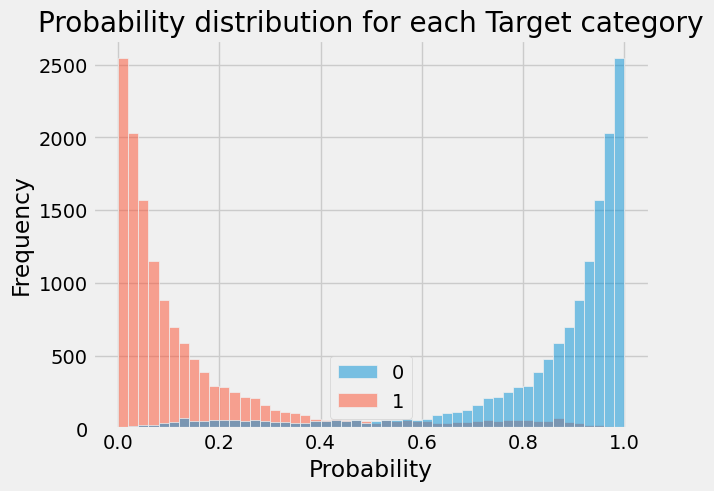

In [ ]:
proba_dist(model, X_test)

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC={auc}')
# print(y_test.value_counts())

AUC=0.9010334867341379


In [ ]:
train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

# Predicciones en el conjunto de prueba
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Precisión en el conjunto de prueba:", test_accuracy)

Precisión en el conjunto de entrenamiento: 0.9937085529671824
Precisión en el conjunto de prueba: 0.9422908772952492


In [ ]:
from sklearn.metrics import classification_report
test_predictions = model.predict(X_test)
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     12305
         1.0       0.77      0.63      0.69      1419

    accuracy                           0.94     13724
   macro avg       0.86      0.80      0.83     13724
weighted avg       0.94      0.94      0.94     13724



In [ ]:
test_predictions = model.predict(X_test)
print(confusion_matrix(y_test, test_predictions))

[[12036   269]
 [  523   896]]


In [ ]:
f31=feature_importance(model, X, y, 31)
f31.append('pahosp1y')
print(f31)

['paclims', 'paswell', 'pagender', 'pamomage', 'padrinkb', 'parafaany', 'pahipe_m', 'paheight', 'padiabe', 'paagey', 'padadage', 'pawheeze', 'pabathehlp', 'pachair', 'pahearaid', 'pacancre', 'palunge_m', 'paeat', 'papaina', 'pacholst', 'pagrossaa', 'paarthre', 'paweight', 'pasmokev', 'paosleep', 'pameds', 'paglasses', 'pastroke', 'pahibpe', 'pafallinj', 'parjudg', 'pahosp1y']


In [ ]:
model.save_model('try2/model_opa.xgb')
joblib.dump(scaler, 'try2/scaler_opa.pkl')
joblib.dump(transformer, 'try2/transformer_opa.pkl')

['try2/transformer_opa.pkl']